<a href="https://colab.research.google.com/github/georgesolis/portafolio/blob/main/Campa%C3%B1a_Mkt_Mailing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Caso N°1 - Campaña de Marketing**


---

Una empresa "X" tiene presupuestado una campaña de marketing en donde desean enviar correos masivos a una base de clientes, sin embargo para mejorar la conversión y optimizar el presupuesto, se busca priorizar a los clientes que tenga mayor probabilidad de conversión mediante mail. Se cuenta con una base de datos histórica en donde se indica que clientes abrieron el mail y que clientes no abrieron el mail.

El proyecto necesita que, mediante el uso de analìtica de datos y machine learning, perfilemos el grupo de clientes que tenga mayor probabilidad de abrir el correo. 


---

*   Población objetivo: Clientes que abrieron el mail.
*   Unidad de análisis: Cliente

In [ ]:
#Instalar los paquetes necesarios:
#!pip install "pycaret[full]"
#!pip install sweetviz

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import types
import matplotlib.mlab as mlab
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
import os
from sklearn.model_selection import train_test_split
from pycaret.classification import *
import sweetviz
import seaborn as sns
import time 
from datetime import date
from datetime import timedelta

In [2]:
# Cargamos el dataset
data = pd.read_csv('campana-Marketing.csv')
data.head()

CLIENTE  EDAD  ANIOS_AFILIACION ESTADO_CIVIL SEXO  CPM   TP  TXTS  \
0        1    62                 3            C    M  405   27    15   
1        2    60                 8            C    F  387   85     5   
2        3    59                 7            C    F  366   44     8   
3        4    47                 8            S    M  244  244     1   
4        5    44                 8            S    F  629  173     4   

  MEDIO_PAGO  TARGET  
0   Efectivo       0  
1         tc       1  
2         tc       1  
3   Efectivo       0  
4         tc       1

**Análisis exploratorio de datos**

In [3]:
eda_obj= sweetviz.analyze(data)

eda_obj.show_html('EDA_CAMPANA_MKT' + '.html', layout='widescreen', scale = 0.8)

                                             |          | [  0%]   00:00 -> (? left)

Report EDA_CAMPANA_MKT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [4]:
data.columns.values

array(['CLIENTE', 'EDAD', 'ANIOS_AFILIACION', 'ESTADO_CIVIL', 'SEXO',
       'CPM', 'TP', 'TXTS', 'MEDIO_PAGO', 'TARGET'], dtype=object)

In [5]:
cat = data[['ESTADO_CIVIL','SEXO','MEDIO_PAGO']]

In [6]:
cat.describe(include='all').transpose()

count unique top freq
ESTADO_CIVIL   500      4   C  292
SEXO           500      2   F  292
MEDIO_PAGO     500      3  tc  258

In [7]:
num = data[['EDAD', 'ANIOS_AFILIACION','CPM', 'TP', 'TXTS']]
num.describe().transpose()

count     mean         std   min    25%    50%     75%  \
EDAD              500.0   50.442   14.436046  18.0   39.0   49.0   61.00   
ANIOS_AFILIACION  500.0    5.248    2.450818   0.0    3.0    6.0    7.00   
CPM               500.0  368.688  306.928730  11.0  177.0  275.5  471.25   
TP                500.0   82.864   68.653070   6.0   37.0   63.0  105.00   
TXTS              500.0    6.286    5.990658   1.0    3.0    4.0    8.00   

                     max  
EDAD                90.0  
ANIOS_AFILIACION     8.0  
CPM               2879.0  
TP                 459.0  
TXTS                54.0

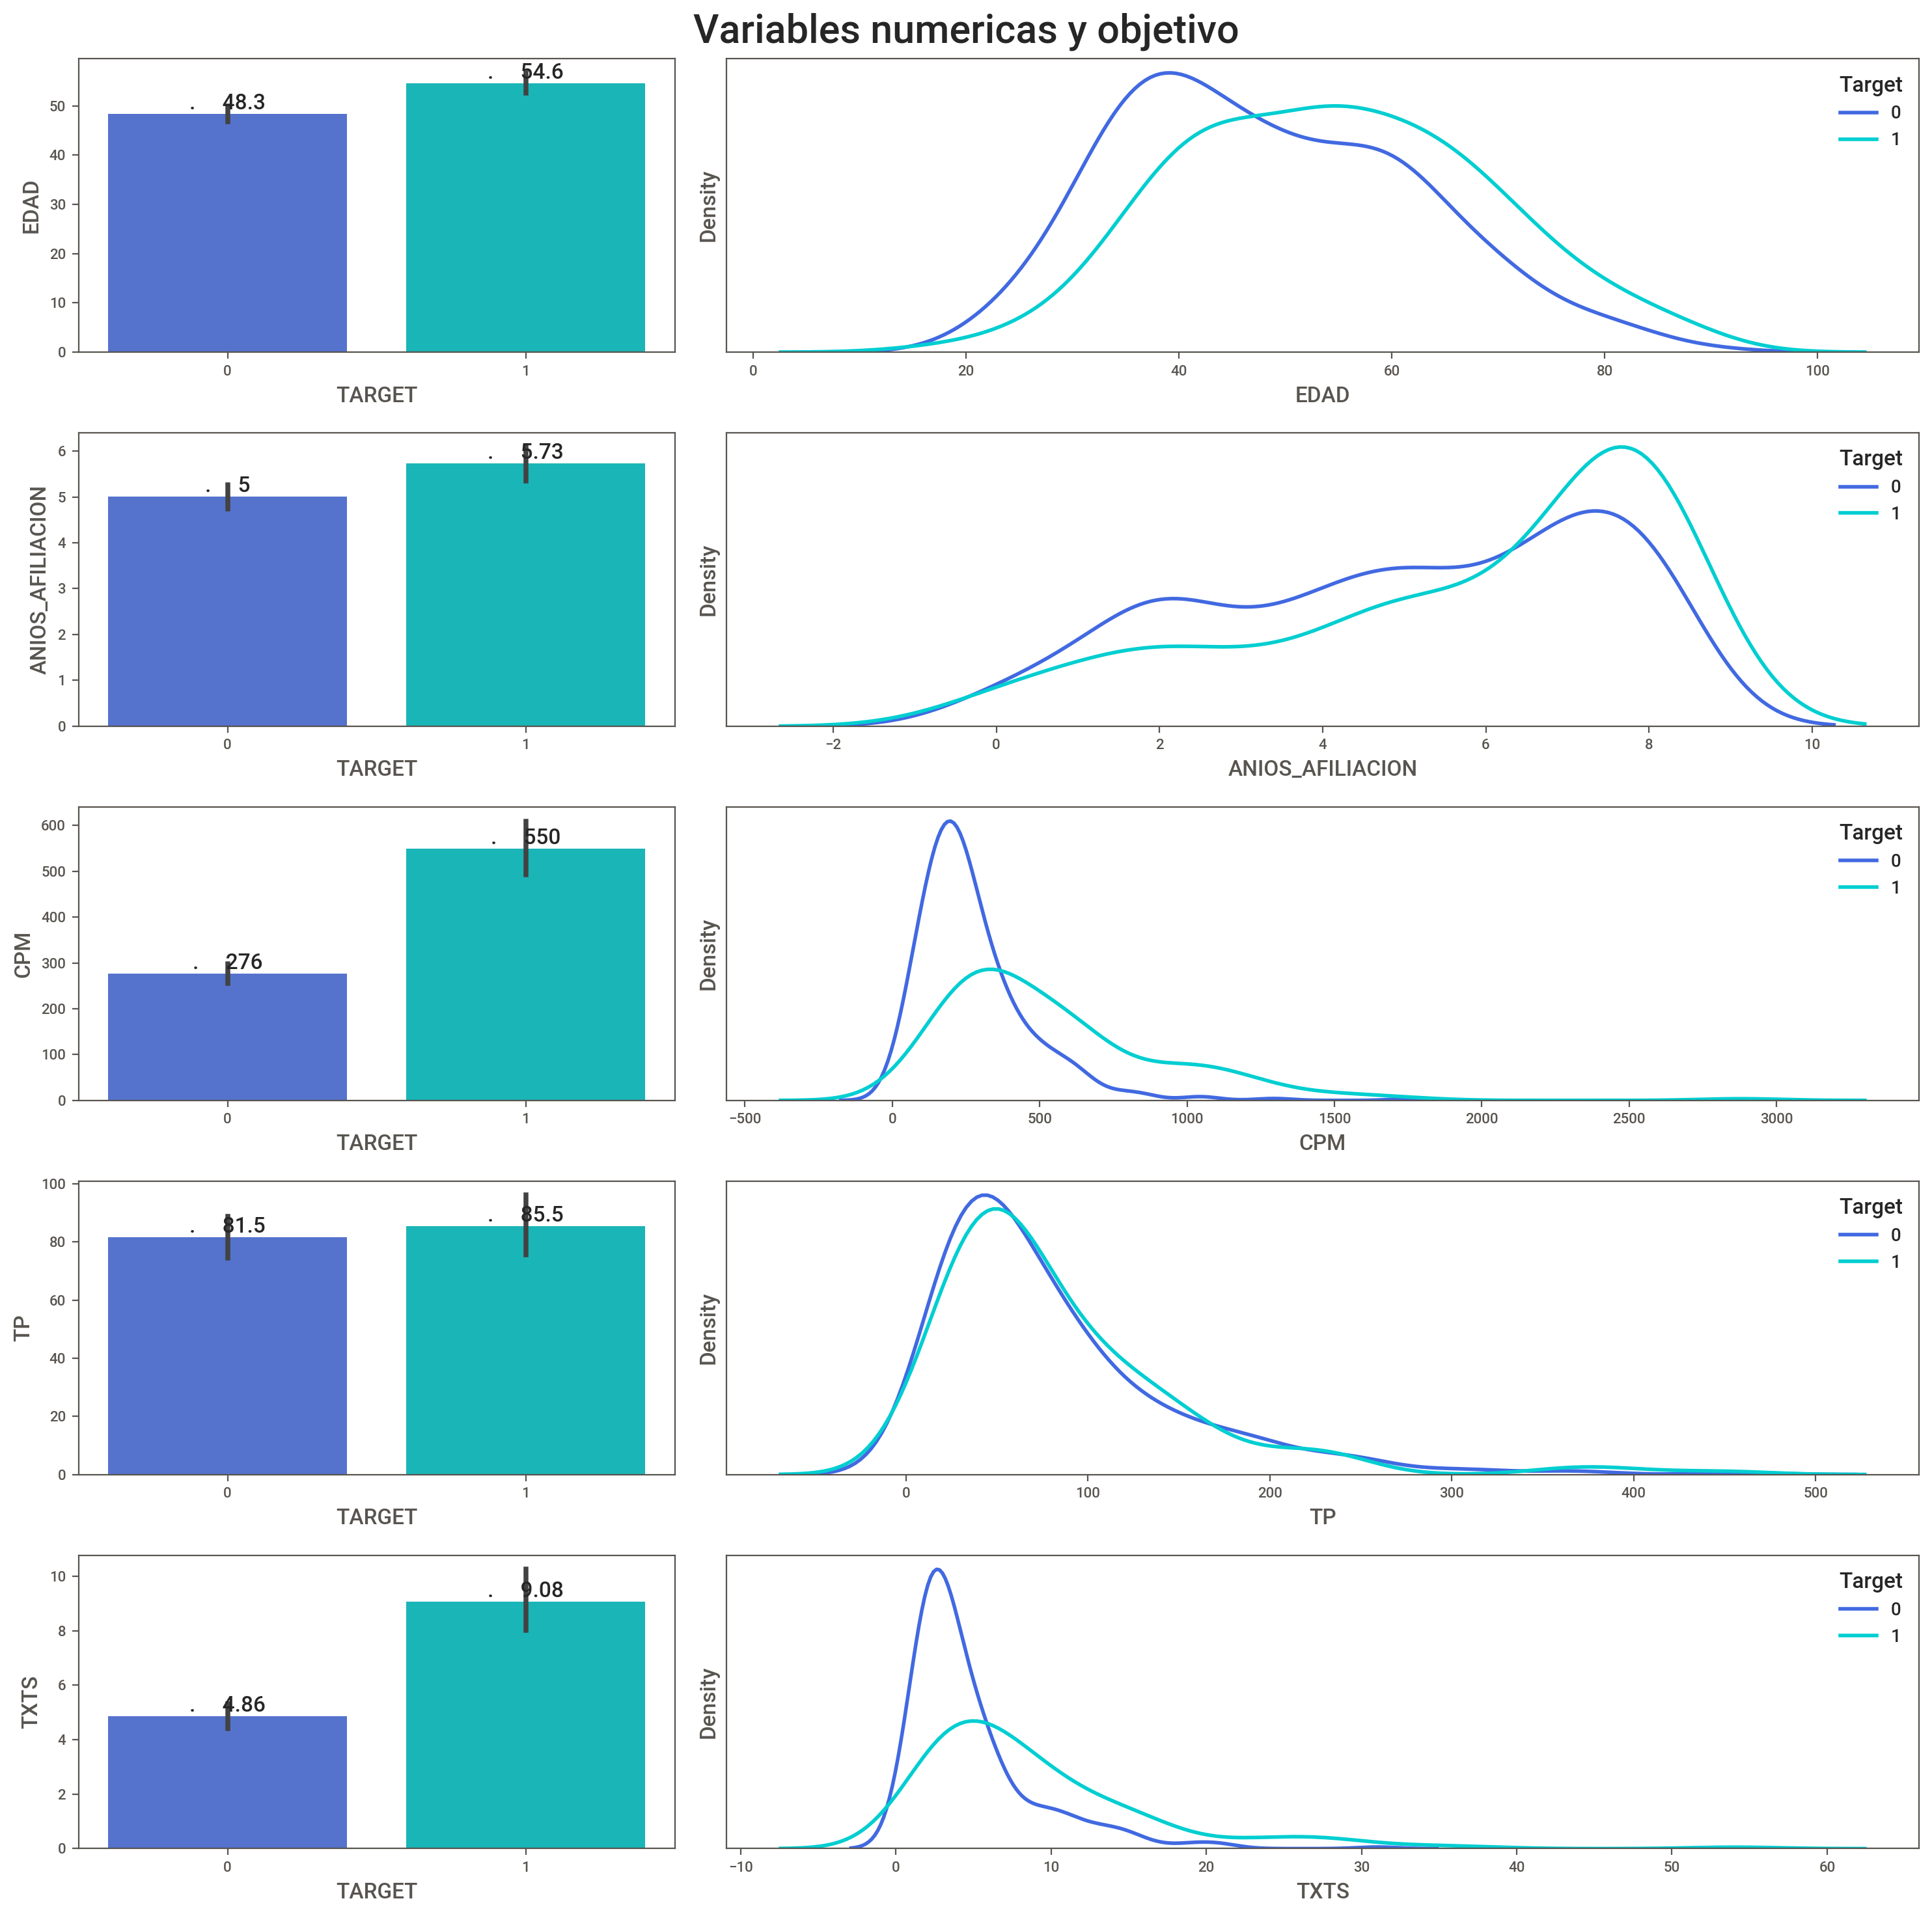

In [8]:
objetivo = 'TARGET'
Num_Features = ['EDAD', 'ANIOS_AFILIACION','CPM', 'TP', 'TXTS']

sns.set_palette(['royalblue','darkturquoise'])
fig, ax = plt.subplots(5,2,figsize=(15,15),dpi=200,gridspec_kw={'width_ratios': [1,2]})
for i,col in enumerate(Num_Features):
    #barplot
    graph = sns.barplot(data=data,x=objetivo, y=col, ax=ax[i,0])
    #kde PLOT
    sns.kdeplot(data=data[data[objetivo]==0],x=col, linewidth=2, ax=ax[i,1],label='0')
    sns.kdeplot(data=data[data[objetivo]==1],x=col, linewidth=2, ax=ax[i,1],label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title="Target",loc='upper right')
    #add bar sizes to our plot
    for cont in graph.containers:
      graph.bar_label(cont, fmt='.     %.3g')

plt.suptitle('Variables numericas y objetivo', fontsize=22)
plt.tight_layout()
plt.show()

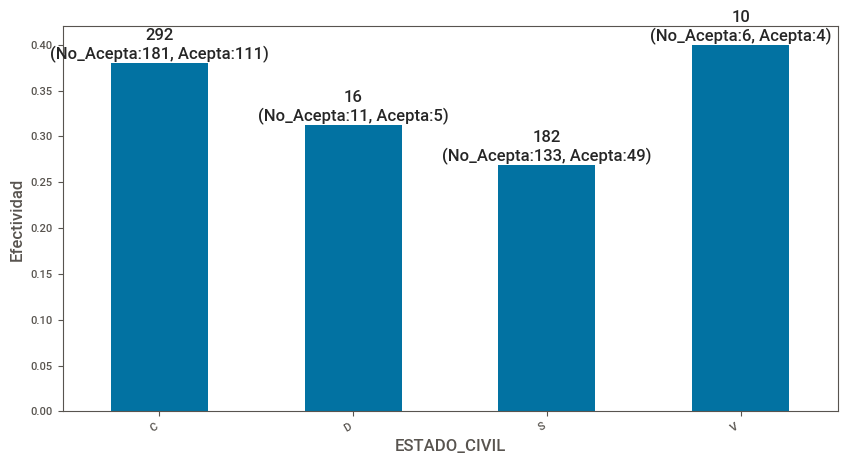

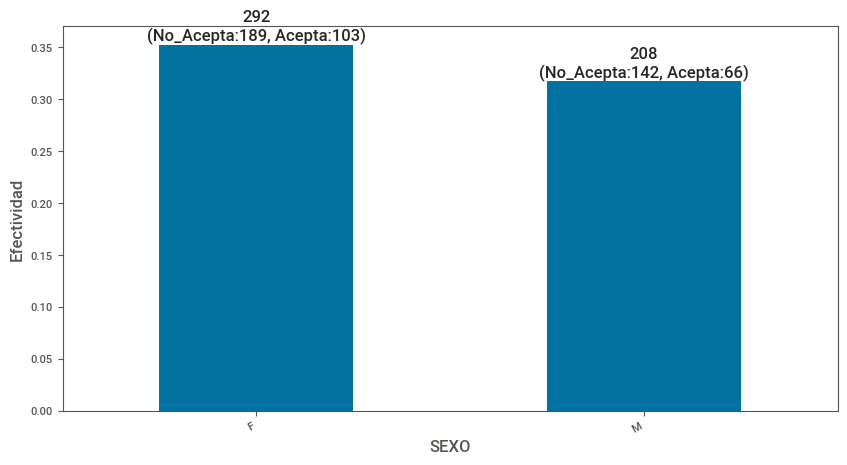

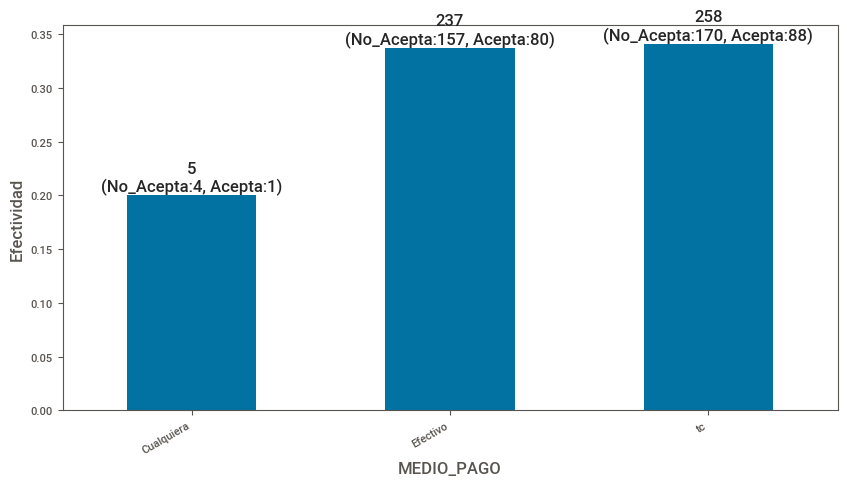

In [9]:
cat_features = ['ESTADO_CIVIL','SEXO','MEDIO_PAGO']
for i in cat_features:
    resumen = pd.concat([data[data.TARGET == 0].groupby(i).TARGET.count()
                          , data[data.TARGET == 1].groupby(i).TARGET.count()], axis=1)
    resumen.columns = ['No_Acepta','Acepta']
    resumen_f = resumen.Acepta / (resumen.Acepta + resumen.No_Acepta)
    plt.figure(figsize=(10,5))
    ax = resumen_f.plot(kind='bar', color='b')
    ax.set_xticklabels(resumen_f.index, rotation=30, fontsize=8, ha='right')
    ax.set_xlabel(i)
    ax.set_ylabel('Efectividad')
    
    # Agregar etiquetas de cantidad de datos
    for j, (valor_acepta, valor_no_acepta) in enumerate(zip(resumen.Acepta, resumen.No_Acepta)):
        total_datos = valor_acepta + valor_no_acepta
        ax.annotate(f'{total_datos}\n(No_Acepta:{valor_no_acepta}, Acepta:{valor_acepta})', xy=(j, resumen_f[j]), ha='center', va='bottom')


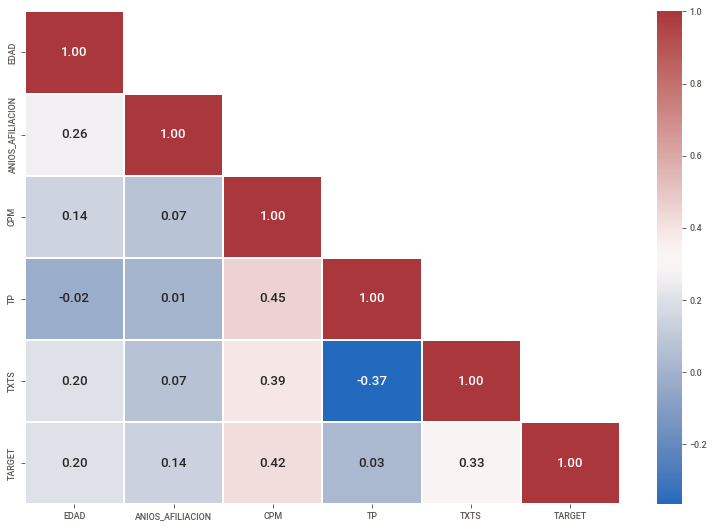

In [10]:
df = data.drop('CLIENTE', axis=1)
#Calculo de Correlación
corr = df.corr(method='pearson')

#Creamos una mascara para ver la correlación en un solo lado
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,1)]=True

#Plot the heatmap correlation
plt.figure(figsize=(12,8),dpi=80)
sns.heatmap(corr, mask=mask, annot=True, cmap = 'vlag', fmt='.2f', linewidths=0.2)
plt.show()

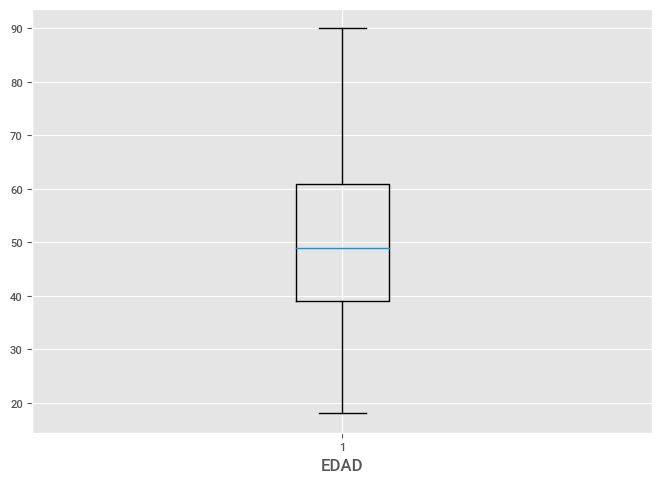

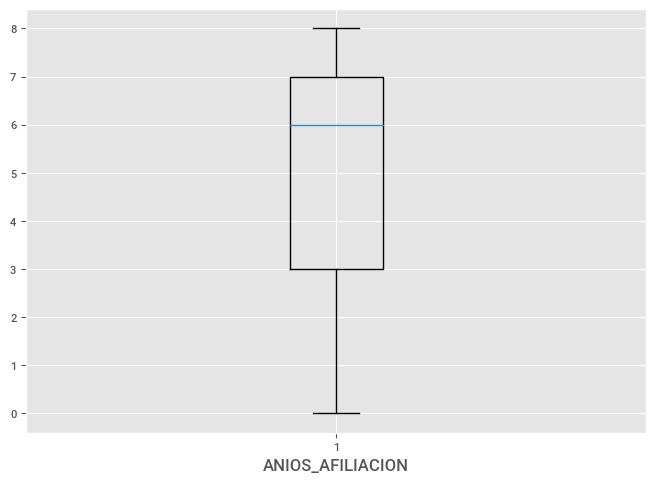

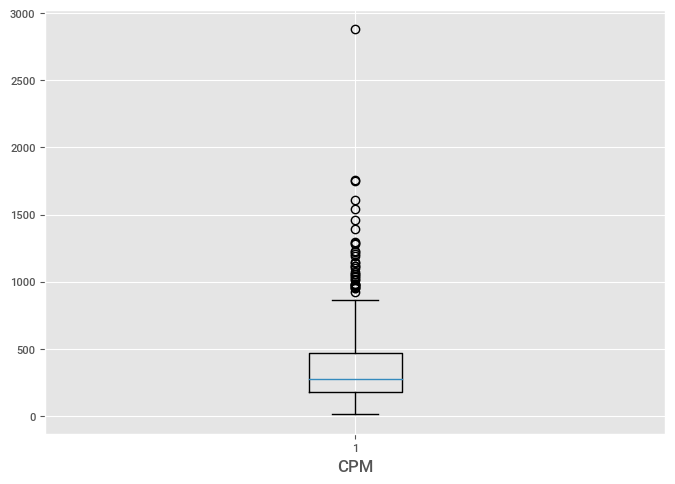

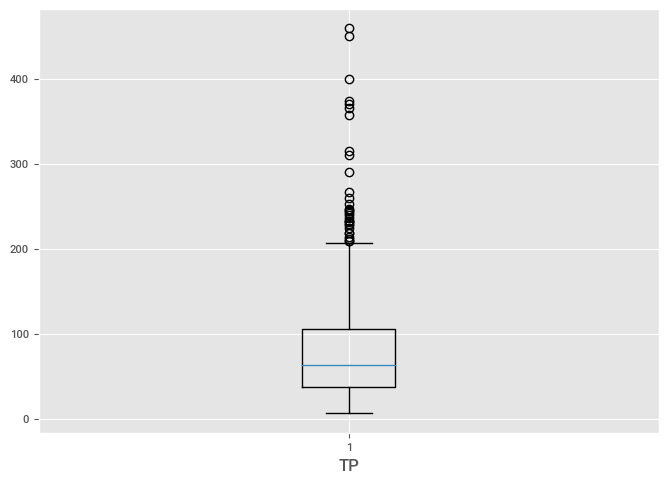

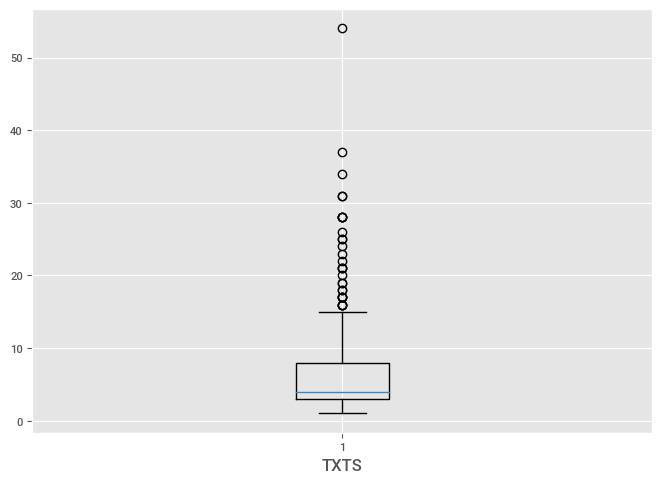

In [11]:
plt.style.use('ggplot')

for i in Num_Features:
    plt.boxplot(data[i])
    plt.xlabel(i)
    plt.show()

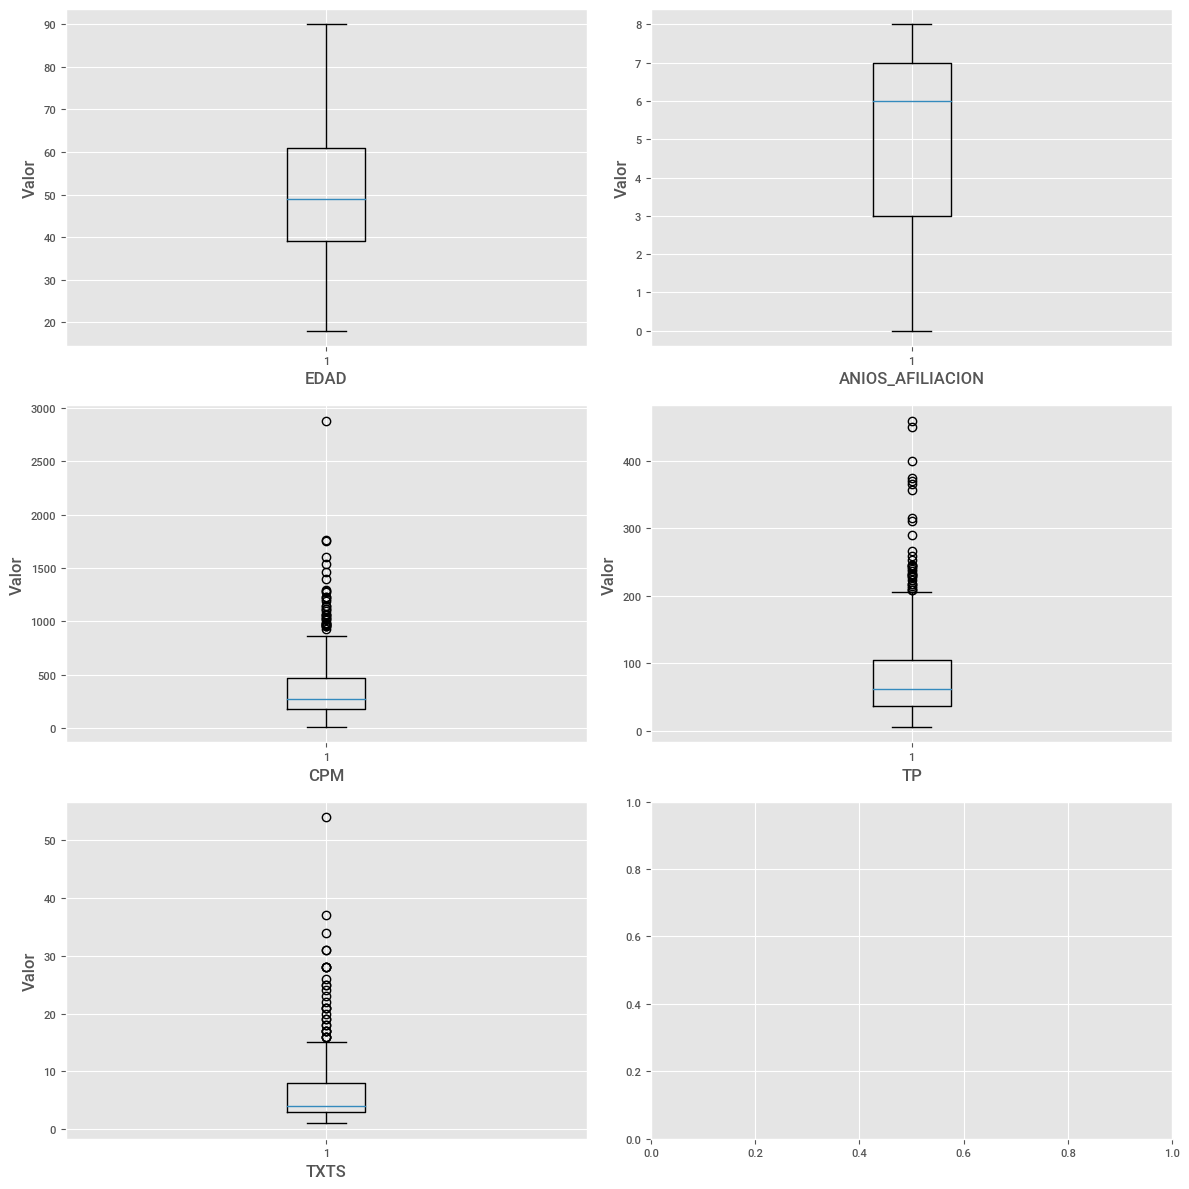

In [12]:
plt.style.use('ggplot')

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

for i, feature in enumerate(Num_Features):
    ax = axs[i // 2, i % 2]  # Obtener la subtrama actual correctamente
    ax.boxplot(data[feature])
    ax.set_xlabel(feature)
    ax.set_ylabel('Valor')
    #ax.set_title(feature)

plt.tight_layout()  # Ajustar el espaciado entre subtramas
plt.show()


Calculamos el coeficiente de asimetría y coeficiente de variación

In [13]:
from scipy import stats 
import pandas as pd


data_ca = {'Variable' : Num_Features,
       'Coeficiente_Asim' : stats.skew(data[Num_Features])}
asim = pd.DataFrame(data_ca)
asim

Variable  Coeficiente_Asim
0              EDAD          0.299534
1  ANIOS_AFILIACION         -0.517769
2               CPM          2.587872
3                TP          2.075812
4              TXTS          2.758936

In [14]:
res_data_num = data[Num_Features].describe().transpose()
res_data_num['cv'] = res_data_num.iloc[:,2] / res_data_num.iloc[:,1] * 100
res_data_num

count     mean         std   min    25%    50%     75%  \
EDAD              500.0   50.442   14.436046  18.0   39.0   49.0   61.00   
ANIOS_AFILIACION  500.0    5.248    2.450818   0.0    3.0    6.0    7.00   
CPM               500.0  368.688  306.928730  11.0  177.0  275.5  471.25   
TP                500.0   82.864   68.653070   6.0   37.0   63.0  105.00   
TXTS              500.0    6.286    5.990658   1.0    3.0    4.0    8.00   

                     max         cv  
EDAD                90.0  28.619100  
ANIOS_AFILIACION     8.0  46.700039  
CPM               2879.0  83.248907  
TP                 459.0  82.850297  
TXTS                54.0  95.301586

**Modelado con PYCARET**

In [15]:
np.seterr(divide = 'ignore', invalid = 'ignore')
s = setup(data,
          target = 'TARGET',
          imputation_type = 'iterative',
          n_jobs=-1,
          remove_outliers = True,
          ignore_features = ['CLIENTE'],
          session_id = 123)

In [16]:
(get_config('y_train').value_counts())/len(get_config('y_train')) *100

0    66.285714
1    33.714286
Name: TARGET, dtype: float64

In [17]:
models()

Name  \
ID                                          
lr                    Logistic Regression   
knn                K Neighbors Classifier   
nb                            Naive Bayes   
dt               Decision Tree Classifier   
svm                   SVM - Linear Kernel   
rbfsvm                SVM - Radial Kernel   
gpc           Gaussian Process Classifier   
mlp                        MLP Classifier   
ridge                    Ridge Classifier   
rf               Random Forest Classifier   
qda       Quadratic Discriminant Analysis   
ada                  Ada Boost Classifier   
gbc          Gradient Boosting Classifier   
lda          Linear Discriminant Analysis   
et                 Extra Trees Classifier   
xgboost         Extreme Gradient Boosting   
lightgbm  Light Gradient Boosting Machine   
catboost              CatBoost Classifier   
dummy                    Dummy Classifier   

                                                  Reference  Turbo  
ID                                                                  
lr        sklearn.linear_model._logistic.LogisticRegression   True  
knn       sklearn.neighbors._classification.KNeighborsCl...   True  
nb                           sklearn.naive_bayes.GaussianNB   True  
dt             sklearn.tree._classes.DecisionTreeClassifier   True  
svm       sklearn.linear_model._stochastic_gradient.SGDC...   True  
rbfsvm                             sklearn.svm._classes.SVC  False  
gpc       sklearn.gaussian_process._gpc.GaussianProcessC...  False  
mlp       sklearn.neural_network._multilayer_perceptron....  False  
ridge           sklearn.linear_model._ridge.RidgeClassifier   True  
rf          sklearn.ensemble._forest.RandomForestClassifier   True  
qda       sklearn.discriminant_analysis.QuadraticDiscrim...   True  
ada       sklearn.ensemble._weight_boosting.AdaBoostClas...   True  
gbc         sklearn.ensemble._gb.GradientBoostingClassifier   True  
lda       sklearn.discriminant_analysis.LinearDiscrimina...   True  
et            sklearn.ensemble._forest.ExtraTreesClassifier   True  
xgboost                       xgboost.sklearn.XGBClassifier   True  
lightgbm                    lightgbm.sklearn.LGBMClassifier   True  
catboost                   catboost.core.CatBoostClassifier   True  
dummy                         sklearn.dummy.DummyClassifier   True

In [19]:
%%time

best = compare_models(sort='f1',
                      fold=10,
                      #include=['dt','rf','lr'],
                      n_select = 3)

Processing:   0%|          | 0/71 [00:00<?, ?it/s]

CPU times: user 12.9 s, sys: 1.04 s, total: 13.9 s
Wall time: 1min 38s


In [22]:
#Capturamos el resultado de la evaluación inicial
best_resumen = pull()
fecha = date.today()
fecha = fecha.strftime("%Y%m%d")
best_resumen.to_excel('resultados_Mod'+fecha+'.xlsx')

In [23]:
#revisamos a detalle los mejores modelos
mod = best[0]
evaluate_model(mod)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [24]:
#Exportamos gràficos del modelo optimizado
plot_model(mod, plot = 'feature',save=True)
plot_model(mod, plot = 'feature_all',save=True)
plot_model(mod, plot = 'confusion_matrix',save=True)
plot_model(mod, plot = 'auc',save=True)
plot_model(mod, plot = 'class_report',save=True)

'Class Report.png'

In [27]:
#predicciones
predict_model(mod)

ValueError: ignored

In [28]:
#finaliza entrenamiento
modelo_final = finalize_model(mod)
save_model(modelo_final, 'modelo_propension_v1')


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('iterative_imputer',
                  TransformerWrapper(exclude=None, include=None,
                                     transformer=IterativeImputer(add_indicator=False,
                                                                  cat_estimator=LGBMClassifier(boosting_type='gbdt',
                                                                                               class_weight=None,
                                                                                               colsample_bytree=1.0,
                                                                                               importance_type='split',
                                                                                               learning_rate=0.1,
                                                                                               max_depth=-1,
                                                                   

**Producción**

In [29]:
ruta_modelo = r'modelo_propension_v1'
modelo = load_model(ruta_modelo)

Transformation Pipeline and Model Successfully Loaded


In [30]:
data = {
    'CLIENTE': [1, 2, 3, 4, 5],
    'EDAD': [62, 60, 59, 47, 44],
    'ANIOS_AFILIACION': [3, 8, 7, 8, 8],
    'ESTADO_CIVIL': ['C', 'C', 'C', 'S', 'S'],
    'SEXO': ['M', 'F', 'F', 'M', 'F'],
    'CPM': [405, 387, 366, 244, 629],
    'TP': [27, 85, 44, 244, 173],
    'TXTS': [15, 5, 8, 1, 4],
    'MEDIO_PAGO': ['Efectivo', 'tc', 'tc', 'Efectivo', 'tc']
}

df = pd.DataFrame(data)

In [31]:
#ejecutamos prediccion
predicciones = predict_model(modelo,raw_score=True, data=df)

In [32]:
#Seleeciono las columnas que necesito (Cliente, predicción de conversión, probabilidad)
dfp = predicciones[['CLIENTE','prediction_label','prediction_score_1']]

In [33]:
#Muestra de clientes
dfp.head(5)

CLIENTE  prediction_label  prediction_score_1
0        1                 1              0.5011
1        2                 0              0.4593
2        3                 1              0.5070
3        4                 0              0.0669
4        5                 0              0.4879